# Order parameters for octahedral tilting in perovskites
In this notebook we will learn the irreps that describe octahedral tilting in perovskites, specifically those in space group $Pnma$ (62).

In [1]:
import torch
import torch_geometric as tg
import e3nn
from e3nn import rs, o3
from e3nn.networks import GatedConvParityNetwork
from e3nn.point.message_passing import Convolution
import e3nn.point.data_helpers as dh
from e3nn.tensor.spherical_tensor import SphericalTensor
import math
import numpy as np
import matplotlib.pyplot as plt

import pymatgen
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

torch.set_default_dtype(torch.float64)

device = "cuda:2"

### Import structures to use for training.
We use structures based on the ICSD Structures 63157 and 16688 for space group $Pm\bar{3}m$ (221) and $Pnma$ (62), respectively. We also make the following modifications:
* transform the parent 221 structure to be in the 62 setting,
  * ...so there's a one-to-one mapping of atoms between the two structures. 
* reshape the unit cells to have equal lattice parameters and replace atom types with site labels $A$, $B$, and $X$,
  * ...while we can deal with changes in lattice size -- we didn't want to complicate this example.
* rotate the 62 setting lattice to match the Cartesian coordinates of cubic setting lattice vectors,
  * ...this makes it easier to interpret the order parameters.
* and remove the $A$ site distortions for the $Pnma$ structures.
  * ...so we can focus on only the irreps of the octahedral distortion.

In [2]:
struct_221_primitive = Structure.from_file('structures/221_orig.cif')
struct_221 = Structure.from_file("structures/221_anon.cif")
struct_62 = Structure.from_file(filename="structures/62_anon_sorted.cif")

rlatt = torch.tensor(struct_221_primitive.lattice.reciprocal_lattice.abc)

# Rotate space group 62 setting lattice to match Cartesian coordinates of cubic setting
new_lattice = o3.rot_z(np.pi / 4.).T @ struct_221.lattice.matrix

struct_221 = Structure(new_lattice, struct_221.species, struct_221.frac_coords)
struct_62 = Structure(new_lattice, struct_62.species, struct_62.frac_coords)

print(struct_221.lattice)
lat = 4.055964

4.055964 4.055964 0.000000
-4.055964 4.055964 0.000000
0.000000 0.000000 8.112000


In [3]:
atom_types_list = ['A', 'B', 'X']
atom_indices = [atom_types_list.index(str(s.species)[0]) for s in struct_221]  # Remove decorators

### We set up the atom type and order parameter inputs.

In [4]:
Rs_order_param = [(1, 0, 1), (1, 0, -1), (1, 1, 1), (1, 1, -1), (1, 2, 1), (1, 2, -1)]
A_input = torch.tensor([1., 0., 0.]).unsqueeze(0)
B_input = torch.tensor([0., 1., 0.]).unsqueeze(0)
X_input = torch.tensor([0., 0., 1.]).unsqueeze(0)
atom_inputs = [A_input, B_input, X_input]
Rs_in = [(3, 0, 1)] + Rs_order_param  # 3 atom types + order parameters
N = len(struct_221)
zeros = torch.zeros(N - 4, rs.dim(Rs_order_param))
# order_param_input = torch.zeros(20, rs.dim(Rs_order_param))
order_param_input = torch.zeros(4, rs.dim(Rs_order_param))
# order_param_input.to(device)
order_param_input.requires_grad = True

lmax = 6

Rs_out = [(1, 1, -1)]
r_max = 3.5

### This function stitches together the fixed atom type inputs and the learnable order parameters.

In [5]:
def create_features(order_param_input):
    order_param = torch.cat([zeros, order_param_input], dim=0)

    N = len(atom_indices)
    all_atom_types = torch.cat([
        atom_inputs[i] for i in atom_indices
    ], dim=0)  # [N, atom_types]

    return torch.cat([all_atom_types, order_param], dim=-1)

### We compute the displacements between the high and low symmetry structures, accounting for periodic boundary conditions.

In [6]:
relative_vecs_62 = []
for i, site in enumerate(struct_221):
    sites = struct_62.get_sites_in_sphere(site.coords, 1., include_index=True, include_image=True)
    sorted_sites = sorted(sites, key=lambda x: x[1])
    r = sorted_sites[0][0].coords - site.coords
    relative_vecs_62.append(r)
relative_vecs_62 = np.stack(relative_vecs_62, axis=0)
pos = torch.tensor(struct_221.cart_coords, dtype=torch.float64)
relative_vecs_62 = torch.tensor(relative_vecs_62, dtype=torch.float64)
print("max distortion in Angstroms (62): ", relative_vecs_62.norm(2, -1).max())

max distortion in Angstroms (62):  tensor(0.2565)


### We define our model and optimizers.

In [7]:
model_kwargs = {
    'convolution': Convolution,
    'Rs_in': Rs_in, 'Rs_out': Rs_out,
    'mul': 6, 'lmax': lmax, 'layers': 3,
    'max_radius': r_max,  # From dataset
    'number_of_basis': 10,
}

model = GatedConvParityNetwork(**model_kwargs)

In [8]:
opt = torch.optim.Adam(model.parameters(), 1e-3)
order_opt = torch.optim.Adam([order_param_input], 1e-3)

### First, we overfit the model without symmetry breaking.

In [9]:
model.load_state_dict(torch.load('param_search_model_overfit.torch')['model'])

<All keys matched successfully>

In [10]:
# # Used to create overfit model
# max_iter = 31

# model.to(device)

# for i in range(max_iter):
#     features = create_features(order_param_input)
#     data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
#     data.to(device)
#     output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
#     loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean()
#     if i % 10 == 0:
#         print("model update: ", loss)
#     opt.zero_grad()
#     loss.backward()
#     opt.step() 

# torch.save({'model': model.state_dict(), 'order_param_input': order_param_input},
#            'param_search_model_overfit.torch')

### Now we train the model to recover the order parameters.
We define a loss function on the order parameter input to encourage sparsity and penalize order parameters of higher order ($L$).

In [11]:
def order_param_loss(order_param_input, Rs_order_param, scale=1e-2):
    loss = scale * order_param_input.abs().mean()
    for i, (m, L, p) in enumerate(Rs_order_param):
        start = rs.dim(Rs_order_param[:i])
        end = rs.dim(Rs_order_param[:i+1])
        # Add a relatively severe penalty for higher L order parameters
        loss = loss + scale * L ** 6 * order_param_input[:, start:end].abs().mean()
    return loss

In [12]:
max_iter = 51

model.to(device)

for i in range(max_iter):
    order_param_input.to('cpu')
    features = create_features(order_param_input)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean()
    if i % 10 == 0:
        print("model update: ", loss)
    opt.zero_grad()
    loss.backward()
    opt.step() 
    
    order_param_input.to('cpu')
    features = create_features(order_param_input)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean().cpu()
    loss = loss + order_param_loss(order_param_input, Rs_order_param, scale=1e-2)
    if i % 10 == 0:
        print("order param update: ", loss)
    order_opt.zero_grad()
    loss.backward()
    order_opt.step() 

model update:  tensor(0.0676, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0676, grad_fn=<AddBackward0>)
model update:  tensor(0.0629, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0623, grad_fn=<AddBackward0>)
model update:  tensor(0.0180, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0244, grad_fn=<AddBackward0>)
model update:  tensor(0.0170, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0176, grad_fn=<AddBackward0>)
model update:  tensor(0.0106, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0104, grad_fn=<AddBackward0>)
model update:  tensor(0.0105, device='cuda:2', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0110, grad_fn=<AddBackward0>)


### The largest contributions are for the `Rs = [(1, 1, 1)]` followed by `Rs = [(1, 2, 1)]`
In this plot, the rows are different B sites and the columns are irreps components. 

In [13]:
Rs_order_param

[(1, 0, 1), (1, 0, -1), (1, 1, 1), (1, 1, -1), (1, 2, 1), (1, 2, -1)]

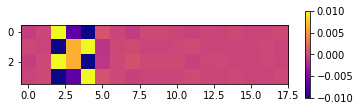

In [24]:
mappable = plt.imshow(order_param_input.detach().numpy(), cmap="plasma", vmin=-0.01, vmax=0.01)
plt.colorbar(mappable, shrink=0.4)

In [15]:
torch.save({'model': model.state_dict(), 'order_param_input': order_param_input},
           'perovskite_order_parameters_determine_irreps.torch')

In [16]:
order_param_input.detach().numpy().round(3)[:, rs.dim(Rs_order_param[:2]): rs.dim(Rs_order_param[:2 + 1])]

array([[ 0.011, -0.007, -0.015],
       [-0.015,  0.007,  0.011],
       [ 0.015,  0.007, -0.011],
       [-0.011, -0.007,  0.015]])

In [17]:
order_param_input.to('cpu')
features = create_features(order_param_input)
data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
data.to(device)
output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)

### Note, the network output does not perfect match the target output.
This is because the octahedra in `structures/62_anon_sorted.cif` are slightly distorted. To capture this additional distortion, we would need to include order parameters for the $X$ sites as well as the $B$ sites.

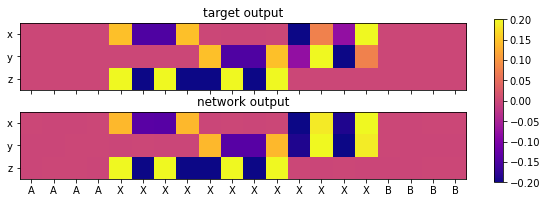

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3))
bound = 0.2
mappable = ax[0].imshow(data.y.cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
ax[1].imshow(output[:, [2, 0, 1]].cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
sites = [str(s.species)[0] for s in struct_62]

ax[0].set_title('target output')
ax[1].set_title('network output')

ax[0].set_xticks(range(len(sites)))
ax[0].set_xticklabels([''] * len(sites))
ax[1].set_xticks(range(len(sites)))
ax[1].set_xticklabels(sites)

ax[0].set_yticks(range(3))
ax[1].set_yticks(range(3))
ax[0].set_yticklabels(['x', 'y', 'z'])
ax[1].set_yticklabels(['x', 'y', 'z'])
fig.colorbar(mappable, ax=ax)

In [19]:
new_struct = Structure(new_lattice, struct_221.species,
                       struct_221.cart_coords + output.cpu()[:, [2, 0, 1]].detach().numpy(),
                       coords_are_cartesian=True)
new_struct.to(filename='recovered_struct.cif')

In [20]:
pga = SpacegroupAnalyzer(new_struct)
pga.get_space_group_number()

62